# **GR5242 HW03 Problem 4: Automatic Differentiation**

**Instructions**: This problem is an individual assignment -- you are to complete this problem on your own, without conferring with your classmates.  You should submit a completed and published notebook to Courseworks; no other files will be accepted.

## Description:

This homework adds more detail to the autodiff lecture in class. There are seven questions (30 points) in total, which include coding and written questions. You can only modify the codes and text within \### YOUR CODE HERE ### and/or \### YOUR ANSWER HERE ###.


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import sympy as sym

## Differentiation

**Different ways of differentiation:** In this problem we consider a particular function (which we call it an `op` in the code block, short for operation) $f:\mathbb{R} \to \mathbb{R}: x \mapsto 4x(1-x)$ and it's compositions with itself. Let us define,
$$ g_n: \underbrace{f \circ \dots \circ f}_{n \text{ times}}: x \mapsto f^{(n)}(x) $$
where $f^{(n)}(x) = f(f^{(n-1)}(x))$ is the $n$ times composited function $f$ with itself. The goal of this problem is to explore various ways of differentiation, i.e. $\frac{d}{dx}g_{n}(x)$ which are listed below:
- Numerical differentiation
- Symbolic differentiation
- Autodiff in forward or reverse mode

In [2]:
def op(inp):
  return 4 * inp * ( 1 - inp )

def operation(inp, n = 1):
	temp = inp
	for i in range(n):
		temp = op(temp) # apply this operation n times
	return temp

## Numerical Differentiation

Based on the definition of derivative at a particular point $x_0$,

$$ \frac{d}{dx}g_n(x_0) = \lim_{h \to 0} \frac{g_n(x_0+h) - g_n(x_0)}{h} =: \lim_{h \to 0} D_h g_n(x_0) $$

The formula above suggests a simple way of **approximating** the derivative by taking $D_{h}g_n(x_0)$ for a particular choice of $h$ as your approximate derivative. This is also known as the [finite difference](https://en.wikipedia.org/wiki/Numerical_differentiation) method. Note that this approach only requires evaluation of your function around the point you are trying to take the derivative at so it's computationally efficient but the caveat is that choosing a proper $h$ to obtain good enough approximations is generally hard (specially when the function is multivariate). However, in our case we have some structure over the function we are trying to take derivative of.

**Question 1 (3 points)**: Use a finite difference with tolerance 1e-12 to approximate the derivative of $g_3(x)$ at $x=1$:

In [9]:
tol = 1e-12
### Your Code Here ###
derivative = (operation(1 + tol, 3) - operation(1, 3)) / tol
print(f'The derivative is {derivative:.4f}')

The derivative is -64.0057


The approximation will be bad at certain points $x$, and becomes less stable as $n$ becomes larger for a fixed $h$ (or as the dimensionality of the function grows).  

## Calculus and (manual/symbolic) differentiation

Notice that $f$ is a polynomial and that composition of polynomials yields also a polynomial. Therefore, $g_n$ is a polynomial with degree $2^n$ (try to argue this for yourself using induction); we can compute the derivative using  calculus.

Instead of computing the derivative by hand we use the help of an auxillary package `sympy` and try to compute the derivative. This package uses symbolic variables and traces operations such as add, multiplication, division, etc., applied onto these variables and computes the derivative using chain rule.

It is not difficult to (manually) derive a closed form expression for $g_n$ using the recursive formula
$$ g_n(x) = 4 g_{n-1}(x) (1-g_{n-1}(x)), \quad g_{1}(x) = 4x(1-x).$$  
The following block of code prints this closed form expression in terms of a symbolic variable `X`.

In [10]:
X = sym.Symbol('X') # Create a symbolic variable
sym.init_printing(use_unicode=False, wrap_line=True)

In [11]:
Y = operation(X, 3)
Y # This line should produce an expression.

Now that we have the closed form expression, we may use the chain rule to express the derivative of $g_n$.

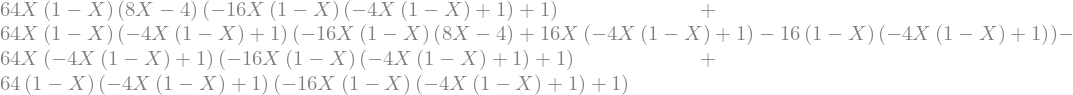

In [36]:
dydx_symbolic = sym.diff(Y, X)
dydx_symbolic

**Question 2 (3 points):** Compute the exact derivative of $g_n(x)$ at $x=1$ by evaluating the symbolic expression.

In [37]:
# hint: read about subs/evalf here: https://docs.sympy.org/latest/modules/numeric-computation.html
### Your Code Here ###
df = sym.lambdify(X, dydx_symbolic)
print(f"The exact derivative is {df(1)}")

The exact derivative is -64


As it is evident the closed form expression for `dydx_symbolic` is unwieldy. We can make it more efficient by expanding and collecting all the terms. The goal is to represent the derivative as a natural polynomial. Yet this is another way of computing the derivative.

**Question 3 (3 points):** Using the `sympy` documentation [page](https://docs.sympy.org/latest/tutorials/intro-tutorial/simplification.html) expand/simplify the closed form expression of $g_n(x)$ and print its derivative as a symbolic expression.

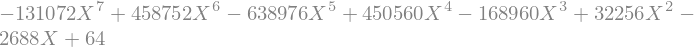

In [34]:
### Your Code Here ###
polynomial = operation(X, 3)
dydx_symbolic_simplified = sym.simplify( sym.diff(polynomial, X) )
dydx_symbolic_simplified # This should express a polynomial of degree 2^n - 1.

Now that we have a compact closed form for the derivative we can evaluate it efficiently at various values of $x$.

**Question 4 (2 points):** Evaluate `dydx_symbolic_simplified` at $x=1$.

In [38]:
### Your Code Here ###
df = sym.lambdify(X, dydx_symbolic_simplified)
print(f"The exact derivative is {df(1)}")

The exact derivative is -64


## Chain Rule and Autodiff

As we've seen in the previous part, symbolic engines computes the derivative using **some** closed form expression of the function. In particular, `sympy` simplified the **recursive** operation and expressed the function $g_n$ in terms of basic operations over the symbolic variable `X`. On the other hand, Autodiff does not necessarily simplify these operations and apply chain rule directly to the latest operation either in forward or backward mode.


**Question 5 (4 points):** Using the recursive representation $g_n(x) = f(g_{n-1}(x))$ calculate the derivative of $g_n$ as a function of $g_{n-1}$ and $g^{'}_{n-1}$.  (To be clear, this part is not code; write the mathematical expression below)

$$ \frac{d}{dx} g_n(x) = \frac{d}{dx} \left( f(g_{n-1}(x)) \right) = \frac{d}{du}  f(u) \rvert_{u = g_{n-1}(x)} \cdot \frac{d}{dx} g_{n-1}(x) $$
We have $f^{\prime}(u) = 4 - 8u$. Simplifying gives:
$$ \frac{d}{dx} g_n(x) = \left( 4 - 8 g_{n-1}(x) \right) \cdot g_{n-1}^{\prime}(x)  $$

This implies that we can compute $g_{n}^{'}(x)$ in the forward mode if we could compute $g_{n-1}(x)$ and $g_{n-1}^{'}(x)$ in the forward mode. Indeed, this is possible by applying the same logic to $g_{n-1}^{'}(x)$ and compute it based on $g_{n-2}(x)$ and $g_{n-2}^{'}(x)$; In other words, by augmenting the forward computation graph $g_1 \to g_2 \dots \to g_n$ with $(g_1, g_1^{'})\to (g_2,g_2^{'}),\dots \to (g_n,g_n^{'})$ we can compute the derivative in a forward pass.

**Question 6 (8 points):** Modify the functions `op` and `operation` with their counterparts `op_with_grad` and `operation_with_grad` using the logic explained above to compute the derivative of $g_n$. Check your function by evaluating it at $x=1$.

In [39]:
### Your Code Here ###
def op_with_grad(inp, grad):
	# inp could be any function of x.
	# grad is the corresponsing derivative of inp with respect to x.
	# The function should return a tuple where the first element is the `op` applied to inp
	# and the second element should be the gradient of op(inp) with respect to x.
	f = 4 * inp * (1 - inp)
	df = (4 - 8 * inp) * grad
	return (f, df)

def operation_with_grad(inp, n = 1):
	# inp represents x here.
	# This function should output a tuple where the first element is the value of g_n(inp)
	# and the second element should be the derivative evaluated at inp, i.e. g_n^'(inp)
	f, df = op_with_grad(inp, 1)
	for _ in range(2, n+1):
		f, df = op_with_grad(f, df)
	return (f, df)

operation_with_grad(1.0, n = 3)

Fortunately, `torch` can do last part for us! As was discussed in class, `torch` interprets our code and builds up a computation graph using operations that knows their gradients already and complements each operation with their backward gradient; in order to compute the gradient it follows the following backwards path

$$ (g_n, \frac{\partial}{\partial g_n}g_n) \to (g_{n-1}, \frac{\partial}{\partial g_{n-1}}g_{n}) \to (g_1, \frac{\partial}{\partial g_1}g_n) \to (g_0, \frac{\partial}{\partial g_0}g_n) $$

where $g_0(x) = x$ is the identity function.

**Question 7 (7 points):** Use PyTorch to calculate the derivative of g_n(x) with respect to x

In [49]:
def torch_op(inp):
  	return 4 * inp * ( 1 - inp )

def torch_operation(inp, n = 1):
	temp = inp
	for _ in range(n):
		temp = torch_op(temp) # apply this operation n times
	return temp

In [57]:
x = torch.tensor(1.0, requires_grad=True)

#### Your code here #####
# define the function with n=3 iterations as before, and use pytorch to autodiff it!
torch_operation(x, n=3).backward()
df_dx = x.grad
print(df_dx.numpy())


-64.0


In [98]:
# just some extra stuff, playing around.
x = torch.tensor([1.05, 1.0, 0.75, 0.5, 0.25, 0.0, -.05], requires_grad=True)
torch_operation(x, n=3).backward(torch.ones_like(x))
df_dx = x.grad
print(df_dx.numpy())

[-303.1826   -64.        -8.         0.         8.        64.
  303.18292]
